# Environment

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import Seq, SeqIO, Entrez
from Bio.Align import PairwiseAligner

In [10]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


# Load functions

In [106]:
def generate_antisense(sequence):
    """Generate the antisense sequence."""
    return str(Seq.Seq(sequence).reverse_complement())

def fetch_gene_sequence(gene_name, email):
    """Fetch the gene sequence from NCBI."""
    Entrez.email = email
    handle = Entrez.esearch(db="nucleotide", term=f"{gene_name}[Gene Name] AND human[Organism]")
    record = Entrez.read(handle)
    if record["IdList"]:
        gene_id = record["IdList"][0]
        handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="gb", retmode="text")
        try:
            gene_record = SeqIO.read(handle, "genbank")
            return str(gene_record.seq)
        except ValueError as e:
            # print(f"Error reading sequence for {gene_name}: {str(e)}")
            return None
        finally:
            handle.close()
    return None

def align_sequence(query, target, allowed_mismatches=1):
    """Perform local alignment and return the best score."""
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.open_gap_score = -1
    aligner.extend_gap_score = -0.5
    try:
        alignments = aligner.align(query, target)
        best_alignment = max(alignments, key=lambda a: a.score)
        mismatches = sum(1 for q, t in zip(best_alignment.query, best_alignment.target) if q != t)
        if mismatches <= allowed_mismatches:
            return [best_alignment.score, mismatches]
        else:
            return [0, mismatches]
    except OverflowError:
        print(f"OverflowError occurred during alignment. Query length: {len(query)}, Target length: {len(target)}")
        return 0

def check_alignment(antisense_seq, gene_list, email, allowed_mismatches, gene_sequences=None):
    """Check alignment of antisense sequence with the given list of genes."""
    results = []
    mismatches = []
    for gene in gene_list:
        if gene_sequences is not None:
            gene_seq = gene_sequences.get(gene)
        else:
            gene_seq = fetch_gene_sequence(gene, email)
        if gene_seq:
            score = align_sequence(antisense_seq, gene_seq, allowed_mismatches)
            if score[0] == len(antisense_seq):  # match
                results.append(gene)
            mismatches.append([gene, score[1]])
            # print(f"Score for {gene}: {score}")
        else:
            print(f"Gene sequence not found for {gene}")
    return [results, mismatches]

# Preparation

In [51]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

In [52]:
selected = ["GEMIN4", "YME1L1", "VCP", "DARS1", "POLR2A", "ORAI1", "POLRMT", "CBX2", "NSD2", "TLE1", "CACNG1", "ZMYND11", "DCAF5", "MED25", "SEMA6A-AS2", "POLD3", "RFT1", "SETDB1", "POLE", "CHD4", "POLR2C", "HTT", "MED14", "PER3", "TOR3A", "EEF1A2", "IL33", "SETD5", "GNRH1", "POLR2E", "IGF1R", "IGF2R", "MTMR1", "EEF2", "RBPMS", "EIF2S3B", "NIPBL", "VCP"]

In [53]:
email = "michal.kubacki11@gmail.com"

In [77]:
antisense_ASE1 = generate_antisense(ASE1)
print(f"Antisense sequence: {antisense_ASE1}")

antisense_ASE2 = generate_antisense(ASE2)
print(f"Antisense sequence: {antisense_ASE2}")

print(len(antisense_ASE1), len(antisense_ASE2))

Antisense sequence: CTTTTCCAAGGAATGTT
Antisense sequence: TTCCGATGAGAATGACG
17 17


# Load gene sequences

In [55]:
fetch_gene_sequence("GEMIN4", email)

'AGCAGGCCTAAGCGCGGCCGCCGTGGCTCCTGCGTCTCCCATCGTGCCGTGCGTCCCGCGCCGCGTTCGAGTTCTCGGAGGGGAGGGGGCGTTAGCCCCGCGCAGCCGCCGGCGTCGCCGCCATGGACCTAGGACCCTTGAACATCTGTGAAGAAATGACTATTCTGCATGGAGGCTTCTTGCTGGCCGAGCAGCTGTTCCACCCTAAGGCACTGGCAGAATTAACAAAGTCTGACTGGGAACGTGTTGGACGGCCCATCGTGGAGGCCTTAAGGGAGATCTCCTCGGCTGCAGCACACTCCCAGCCCTTTGCCTGGAAGAAGAAAGCCCTGATCATCATCTGGGCCAAGGTTCTGCAGCCGCACCCCGTGACCCCGTCCGACACAGAGACACGGTGGCAGGAAGACCTGTTCTTCTCGGTGGGCAACATGATCCCCACCATCAACCACACCATCCTCTTCGAGCTGCTCAAATCCCTGGAAGCTTCTGGACTCTTTATCCAGCTCCTGATGGCCCTGCCCACCACCATCTGCCATGCAGAACTAGAGCGCTTTCTGGAACATGTGACCGTTGACACTTCTGCCGAAGACGTGGCCTTCTTCCTGGACGTCTGGTGGGAGGTGATGAAGCACAAGGGTCACCCGCAGGACCCCCTGCTCTCCCAGTTTAGTGCAATGGCCCATAAGTACCTGCCTGCCTTAGATGAGTTCCCCCATCCTCCAAAGAGGCTTAGGTCAGACCCAGACGCGTGCCCCACCATGCCCCTGTTGGCCATGCTGCTCCGCGGGCTGACACAGATCCAGAGTCGGATCCTGGGCCCGGGGAGGAAGTGCTGTGCGCTGGCCAACCTGGCTGACATGCTGACTGTGTTTGCGCTGACAGAGGACGACCCCCAGGAGGTGTCTGCAACCGTGTATCTGGACAAACTGGCCACGGTGATCTCTGTGTGGAACTCGGACACCCAGAATCCCTACCACCAGCAGGCGCTGGCAGAGAAGG

In [66]:
# Fetch and store gene sequences
gene_sequences = {}
for gene in selected:
    sequence = fetch_gene_sequence(gene, email)
    if sequence:
        gene_sequences[gene] = sequence
    else:
        print(f"Failed to fetch sequence for {gene}")

print(f"Successfully fetched sequences for {len(gene_sequences)} out of {len(selected)} genes")

Error reading sequence for DARS1: Sequence content is undefined
Failed to fetch sequence for DARS1
Error reading sequence for POLR2A: Sequence content is undefined
Failed to fetch sequence for POLR2A
Error reading sequence for CACNG1: Sequence content is undefined
Failed to fetch sequence for CACNG1
Error reading sequence for SEMA6A-AS2: Sequence content is undefined
Failed to fetch sequence for SEMA6A-AS2
Error reading sequence for POLR2C: Sequence content is undefined
Failed to fetch sequence for POLR2C
Error reading sequence for TOR3A: Sequence content is undefined
Failed to fetch sequence for TOR3A
Error reading sequence for EEF1A2: Sequence content is undefined
Failed to fetch sequence for EEF1A2
Error reading sequence for GNRH1: Sequence content is undefined
Failed to fetch sequence for GNRH1
Error reading sequence for EIF2S3B: Sequence content is undefined
Failed to fetch sequence for EIF2S3B
Successfully fetched sequences for 28 out of 38 genes


In [68]:
# Save the gene sequences to a file
import json

with open('./output/gene_sequences.json', 'w') as f:
    json.dump(gene_sequences, f)

print("Gene sequences saved to gene_sequences.json")

Gene sequences saved to gene_sequences.json


In [69]:
# Load the gene sequences from the file
with open('./output/gene_sequences.json', 'r') as f:
    loaded_gene_sequences = json.load(f)

print(f"Loaded {len(loaded_gene_sequences)} gene sequences from file")

Loaded 28 gene sequences from file


In [118]:
aligned_genes_ASE1 = check_alignment(antisense_ASE1, selected, email, allowed_mismatches=3, gene_sequences=loaded_gene_sequences)

Gene sequence not found for DARS1
Gene sequence not found for POLR2A
Gene sequence not found for CACNG1
Gene sequence not found for SEMA6A-AS2
Gene sequence not found for POLR2C
Gene sequence not found for TOR3A
Gene sequence not found for EEF1A2
Gene sequence not found for GNRH1
Gene sequence not found for EIF2S3B


In [119]:
print("Alignment results for ASE1:")
for gene in aligned_genes_ASE1[0]:
    print(gene)

Alignment results for ASE1:


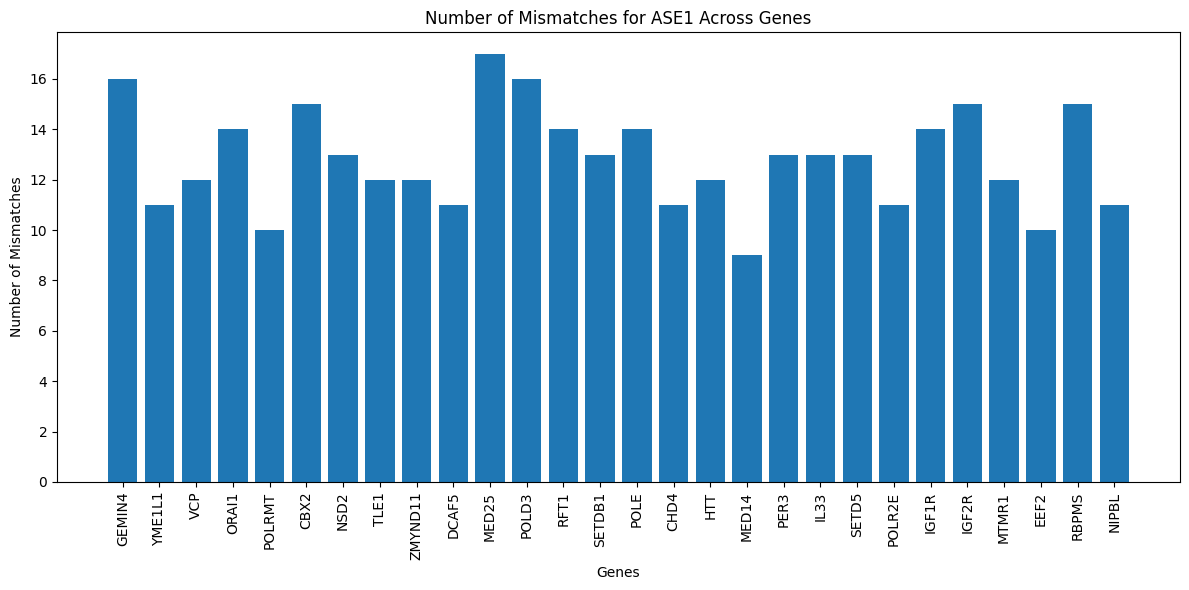


Total mismatches: 359
Average mismatches per gene: 12.82
Genes with most mismatches: MED25
Genes with least mismatches: MED14


In [120]:
mismatches = {}
for gene, mismatch in aligned_genes_ASE1[1]:
    # print(f"{gene}: {mismatch}")
    mismatches[gene] = mismatch

# Visualize the number of mismatches
plt.figure(figsize=(12, 6))
plt.bar(list(mismatches.keys()), list(mismatches.values()))
plt.title("Number of Mismatches for ASE1 Across Genes")
plt.xlabel("Genes")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and print some statistics
total_mismatches = sum(mismatches.values())
avg_mismatches = total_mismatches / len(mismatches)
print(f"\nTotal mismatches: {total_mismatches}")
print(f"Average mismatches per gene: {avg_mismatches:.2f}")
print(f"Genes with most mismatches: {max(mismatches, key=mismatches.get)}")
print(f"Genes with least mismatches: {min(mismatches, key=mismatches.get)}")

In [116]:
aligned_genes_ASE2 = check_alignment(antisense_ASE2, selected, email, allowed_mismatches=3, gene_sequences=loaded_gene_sequences)


Gene sequence not found for DARS1
Gene sequence not found for POLR2A
Gene sequence not found for CACNG1
Gene sequence not found for SEMA6A-AS2
Gene sequence not found for POLR2C
Gene sequence not found for TOR3A
Gene sequence not found for EEF1A2
Gene sequence not found for GNRH1
Gene sequence not found for EIF2S3B


In [121]:
print("Alignment results for ASE2:")
for gene in aligned_genes_ASE2[0]:
    print(gene)

Alignment results for ASE2:


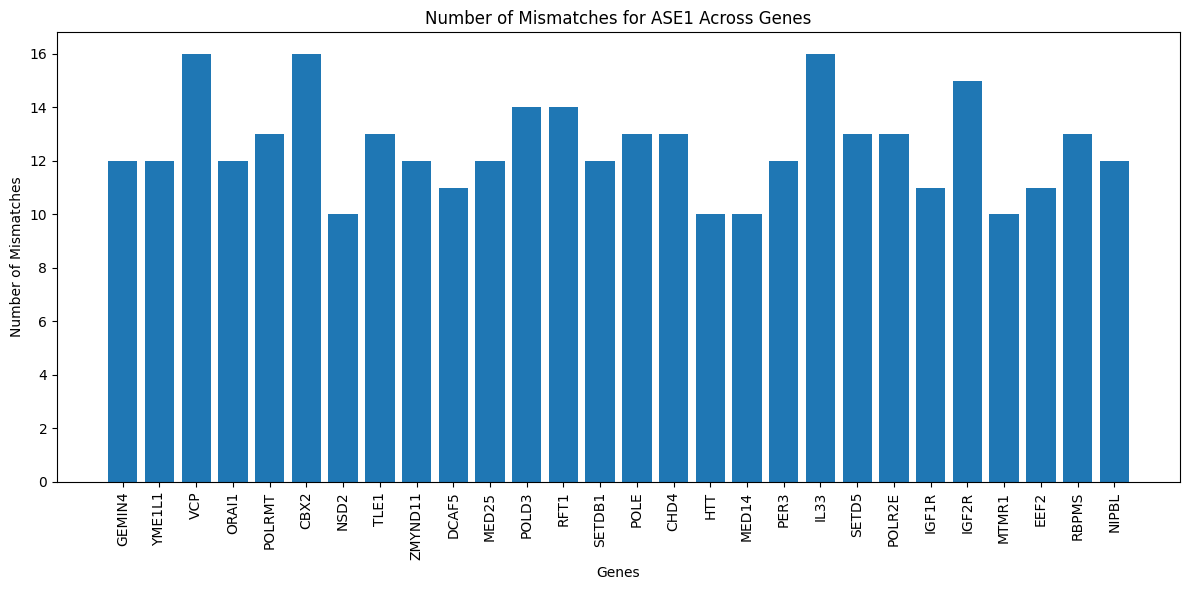


Total mismatches: 351
Average mismatches per gene: 12.54
Genes with most mismatches: VCP
Genes with least mismatches: NSD2


In [122]:
mismatches = {}
for gene, mismatch in aligned_genes_ASE2[1]:
    # print(f"{gene}: {mismatch}")
    mismatches[gene] = mismatch

# Visualize the number of mismatches
plt.figure(figsize=(12, 6))
plt.bar(list(mismatches.keys()), list(mismatches.values()))
plt.title("Number of Mismatches for ASE1 Across Genes")
plt.xlabel("Genes")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and print some statistics
total_mismatches = sum(mismatches.values())
avg_mismatches = total_mismatches / len(mismatches)
print(f"\nTotal mismatches: {total_mismatches}")
print(f"Average mismatches per gene: {avg_mismatches:.2f}")
print(f"Genes with most mismatches: {max(mismatches, key=mismatches.get)}")
print(f"Genes with least mismatches: {min(mismatches, key=mismatches.get)}")